In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import math
import os
import pandas as pd
import shutil

import cv2

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Загрузка данных**

In [ ]:
# Путь к папке с файлами на Google Диске
path = '/content/drive/My Drive/тестовое'

train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df = pd.read_csv(os.path.join(path, 'test.csv'))

In [ ]:
train_df.head()

id  target
0   gL5fWrgNPU.jpg       0
1   KKWXJDN8uM.png       1
2   Wb2I0CXlAY.jpg       0
3  G7PLhKpaf7.jpeg       1
4   DEUkeefz6Z.jpg       0

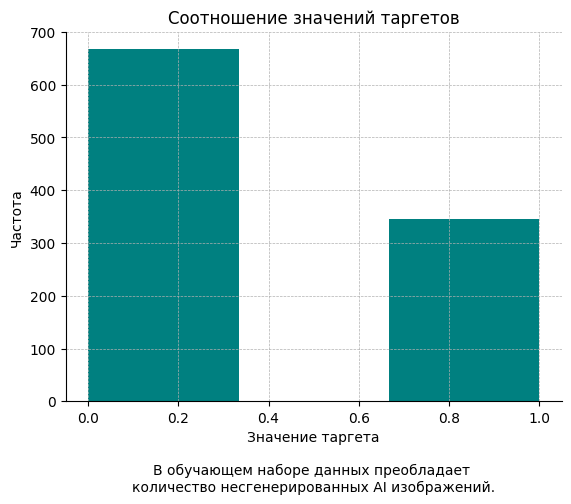

In [ ]:
train_df['target'].plot(kind='hist', bins=3, color='teal', title='Соотношение значений таргетов')
plt.xlabel('Значение таргета')
plt.ylabel('Частота')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.text(0.5, -170, 'В обучающем наборе данных преобладает \nколичество несгенерированных AI изображений.', ha='center')
plt.show()

In [ ]:
test_df.head()

id
0  Qt1fGUB0Vz.jpeg
1  j4Rhioq7R3.jpeg
2  rD0hgFHJUZ.jpeg
3  aY5z1EJsJ6.jpeg
4  qZ3IoxD2TE.jpeg

In [ ]:
# Функция для добавления расширения .png к названиям картинок без расширения
def add_extension(image_name):
    if '.' not in image_name:
        return image_name + '.png'
    else:
        return image_name

In [ ]:
datasets = [test_df, train_df]

# Проход по значениям столбца id и добавление расширения .png к названиям картинок без расширения
for dataset in datasets:
    test_df['id'] = test_df['id'].apply(add_extension)
    train_df['id'] = train_df['id'].apply(add_extension)

In [ ]:
train_df.shape

(1012, 2)

In [ ]:
print(f'Размер обучащей выборки: {train_df.shape}')
print(f'Размер тестовой выборки: {test_df.shape}')

Размер обучащей выборки: (1012, 2)
Размер тестовой выборки: (506, 1)


In [ ]:
print('Общее количество изображений:', len(train_df['id']) + len(test_df['id']))

Общее количество изображений: 1518


In [ ]:
# Отображение нескольких изображений из тренировочной выборки
train_images_path = os.path.join(path, 'images')
train_sample_images = train_df['id'].sample(8)  # Выбор случайных изображений
plt.figure(figsize=(20, 10))
for i, image_id in enumerate(train_sample_images):
    img = Image.open(os.path.join(train_images_path, f'{image_id}'))
    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [ ]:
# Отображение нескольких изображений из тестовой выборки
test_images_path = os.path.join(path, 'images')
test_sample_images = test_df['id'].sample(8)
plt.figure(figsize=(20, 10))
for i, image_id in enumerate(test_sample_images):
    img = Image.open(os.path.join(test_images_path, f'{image_id}'))
    plt.subplot(1, 8, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

Файлы предварительно были автоматически перенесены в папки train и test с помощью кода ниже:

```
output_folder = 'train'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folder = 'test'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Список для хранения проблемных файлов
problematic_files = []

# Перебираем все изображения в папке
for image_file in os.listdir(images_folder):
    # Проверяем, есть ли название изображения в таблице test.csv
    if image_file in test_data['id'].values:
        shutil.copy(os.path.join(images_folder, image_file), 'test/' + image_file)
    # Проверяем, есть ли название изображения в таблице train.csv
    elif image_file in train_data['id'].values:
        shutil.copy(os.path.join(images_folder, image_file), 'train/' + image_file)
    else:
        problematic_files.append(image_file)

# Выводим список проблемных файлов
if problematic_files:
    print("Проблемные файлы, не удалось опредить в одну из выборок:")
    for file in problematic_files:
        print(file)
else:
    print("Все файлы были успешно отнесены в соответствующие папки.")
```

Количество проблемный файлов составило 249. Они не были включены в дальнейшее обучение.


## **Предобработка данных**

In [ ]:
train_path = '/content/drive/My Drive/тестовое/train/'
test_path = '/content/drive/My Drive/тестовое/test/'

In [ ]:
# Функция для загрузки и предобработки изображений
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (256, 256))  # Изменяем размер изображения на 224x224
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразуем цветовую схему BGR в RGB
            images.append(img)
    return np.array(images)

In [ ]:
# Загружаем изображения из папок "train" и "test"
train_images = load_images_from_folder(train_path)
test_images = load_images_from_folder(test_path)

In [ ]:
# Нормализуем значения пикселей изображений
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
print("Размер массива изображений из тренировочной выборки:", train_images.shape)
print("Размер массива изображений из тестовой выборки:", test_images.shape)

Размер массива изображений из тренировочной выборки: (1012, 256, 256, 3)
Размер массива изображений из тестовой выборки: (506, 256, 256, 3)


В тренировочной выборке содержится 846 изображений размером 128х128 пикселя каждое, с тремя каналами цвета (RGB). В тестовой по аналогии содержатся 423 файла.

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.axis('off')
plt.show()

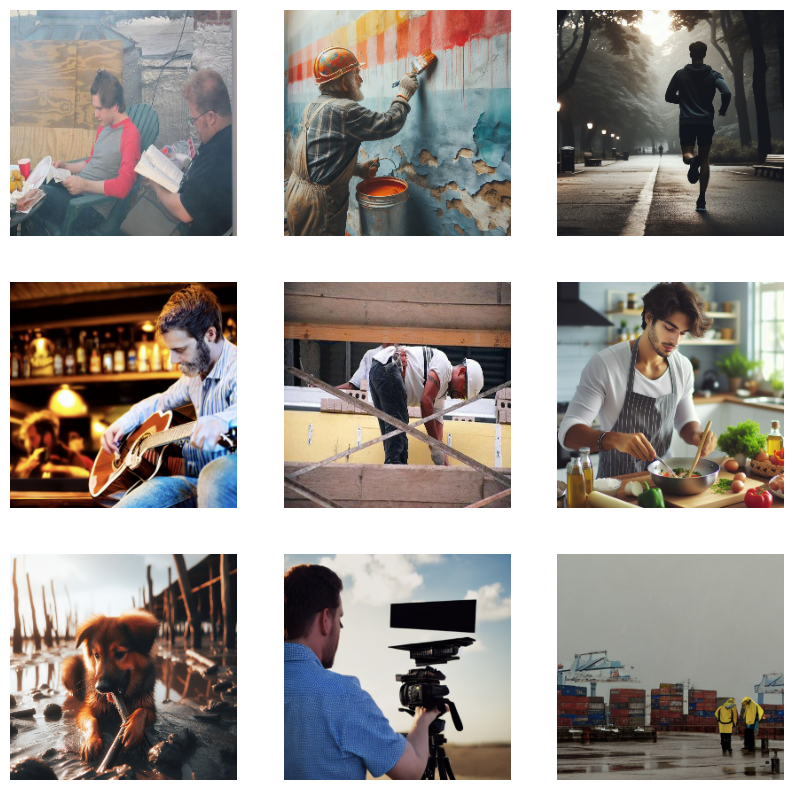

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
plt.show()

In [ ]:
folder_path = '/content/drive/My Drive/тестовое/train/'

# Создаем новый датасет для хранения отфильтрованных данных
filtered_train_df = pd.DataFrame(columns=train_df.columns)

for file_name in os.listdir(folder_path):
    if file_name in train_df['id'].values:
        filtered_train_df = pd.concat([filtered_train_df, train_df[train_df['id'] == file_name]])

In [ ]:
# Преобразование данных в столбце 'target' к типу float
filtered_train_df['target'] = filtered_train_df['target'].astype(float)

In [ ]:
filtered_train_df.shape

(1012, 2)

In [ ]:
# Разделение тренировочных данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(train_images, filtered_train_df['target'], test_size=0.2, random_state=42)

In [ ]:
folder_path = '/content/drive/My Drive/тестовое/test/'

# Создаем новый датасет для хранения отфильтрованных данных
filtered_test_df = pd.DataFrame(columns=test_df.columns)

for file_name in os.listdir(folder_path):
    if file_name in test_df['id'].values:
        filtered_test_df = pd.concat([filtered_test_df, test_df[test_df['id'] == file_name]])

In [ ]:
filtered_test_df.shape

(506, 1)

## **Обучение нейросети**

### **Спецификация №1**

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#model_1.summary()

In [ ]:
utils.plot_model(model_1, dpi=60, show_shapes=True)

In [ ]:
# Обучение модели на тренировочных данных
history_1 = model_1.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/50
51/51 [==============================] - 30s 563ms/step - loss: 0.6829 - accuracy: 0.6415 - val_loss: 0.6046 - val_accuracy: 0.6798
Epoch 2/50
51/51 [==============================] - 27s 532ms/step - loss: 0.5896 - accuracy: 0.6539 - val_loss: 0.5441 - val_accuracy: 0.6798
Epoch 3/50
51/51 [==============================] - 29s 562ms/step - loss: 0.5575 - accuracy: 0.6576 - val_loss: 0.5951 - val_accuracy: 0.6749
Epoch 4/50
51/51 [==============================] - 30s 589ms/step - loss: 0.5389 - accuracy: 0.6811 - val_loss: 0.5134 - val_accuracy: 0.7291
Epoch 5/50
51/51 [==============================] - 28s 559ms/step - loss: 0.5141 - accuracy: 0.7244 - val_loss: 0.5196 - val_accuracy: 0.7488
Epoch 6/50
51/51 [==============================] - 28s 558ms/step - loss: 0.5128 - accuracy: 0.7293 - val_loss: 0.5133 - val_accuracy: 0.7340
Epoch 7/50
51/51 [==============================] - 29s 562ms/step - loss: 0.4160 - accuracy: 0.7973 - val_loss: 0.4662 - val_accuracy: 0.8030

In [ ]:
filtered_test_df['target'] = ""

In [ ]:
test_loss, test_acc = model_1.evaluate(test_images, filtered_test_df['target'])
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 [==============================] - 4s 254ms/step - loss: 4.5933 - accuracy: 0.4012
Test Loss: 4.593271255493164
Test Accuracy: 0.4011857807636261


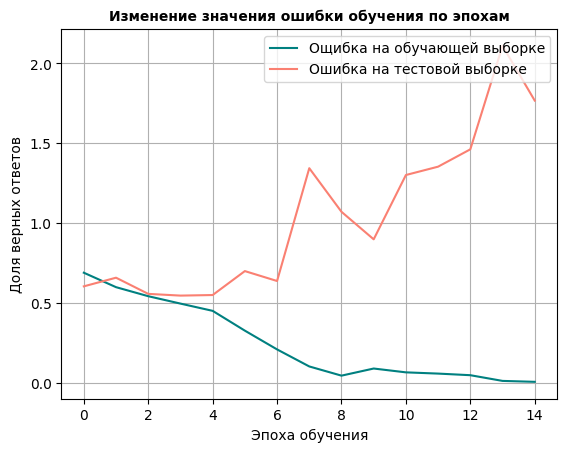

In [ ]:
fig = plt.figure()
plt.plot(history_1.history['loss'], label='Ощибка на обучающей выборке', color='teal')
plt.plot(history_1.history['val_loss'], label='Ошибка на тестовой выборке', color='salmon')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения ошибки обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Видно, что ошибка на тестовой выборке растет, это может указывать на переобучение модели. Переобучение происходит, когда модель слишком хорошо "запоминает" обучающие данные, что приводит к уменьшению ее обобщающей способности.

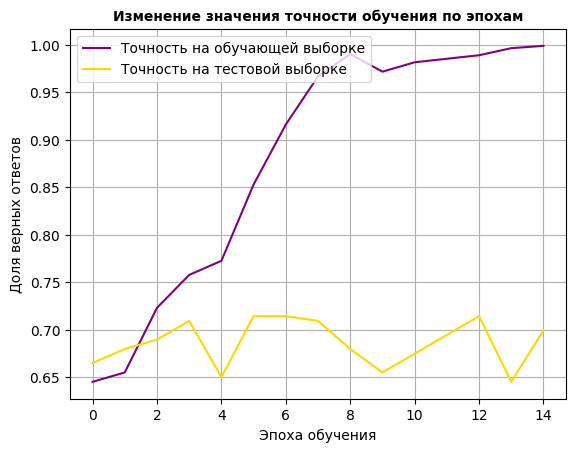

In [ ]:
fig = plt.figure()
plt.plot(history_1.history['accuracy'], label='Точность на обучающей выборке', color='purple')
plt.plot(history_1.history['val_accuracy'], label='Точность на тестовой выборке', color='gold')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения точности обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Видим, что значение точности значительно не растет с увеличением эпох, что также говорит о плохой работе сети. Она не сможет обобщить знания на новых данных.

In [ ]:
# Предсказываем вероятности на тестовой выборке
predicted_probabilities = model_1.predict(test_images)

16/16 [==============================] - 0s 20ms/step


In [ ]:
# Создаем столбец 'target' в датасете filtered_test_df и заполняем его предсказанными вероятностями
filtered_test_df['target'] = predicted_probabilities

In [ ]:
filtered_test_df.head()

id    target
333  11kFDwoijA.jpeg  0.630770
458  0R1JRbHS33.jpeg  0.275748
416   0HBgVT0VvK.png  0.999710
429   10Slzb9e4j.png  0.000369
287  11ynarQSJR.jpeg  0.994530

In [ ]:
print(filtered_test_df.shape)  # ожидаемый вывод - (506, 2)

(506, 2)


In [ ]:
filtered_test_df.describe()

target
count  5.060000e+02
mean   3.436213e-01
std    4.366573e-01
min    2.754708e-34
25%    6.799438e-06
50%    1.677158e-02
75%    9.277380e-01
max    1.000000e+00

* **Среднее значение вероятностей** по всем изображениям составляет **1.246**, что может служить ориентиром для общей уверенности модели в предсказаниях.
* Стандартное отклонение вероятностей составляет 0.270, что указывает на разброс значений вероятностей.

**Над чем можно подумать, чтобы улучшить работу сети?**

* Для улучшения работы сверточной нейронной сети (CNN) для классификации изображений и предсказания вероятности того, что изображение было сгенерировано с помощью искусственного интеллекта (ИИ), можно применить следующие методы и подходы:

* Увеличение объема данных: Дополнение обучающего набора данных с использованием аугментации изображений (например, повороты, отражения, изменение масштаба) может помочь улучшить обобщающую способность модели.

* Выбор архитектуры сети: Попробуйте различные архитектуры CNN, такие как ResNet, Inception, DenseNet и другие, чтобы найти наиболее подходящую для данной задачи.

* Тонкая настройка (Fine-tuning): Используйте предварительно обученные модели (например, на ImageNet) и проведите тонкую настройку последних слоев сети для вашей конкретной задачи.

* Регуляризация: Применение методов регуляризации, таких как Dropout, L2 регуляризация, может помочь в борьбе с переобучением.

* Оптимизация гиперпараметров: Экспериментируйте с различными значениями гиперпараметров, такими как learning rate, batch size, количество эпох обучения, чтобы найти оптимальные параметры.

* Ансамблирование моделей: Попробуйте объединить несколько моделей CNN в ансамбль для улучшения обобщающей способности и повышения точности предсказаний.

* Использование Transfer Learning: Перенос обучения с предварительно обученных моделей на схожих задачах может значительно ускорить процесс обучения и улучшить результаты.

* Оценка результатов: Важно проводить анализ результатов модели, оценивать метрики качества (например, точность, полнота), а также изучать ошибки модели для дальнейшего улучшения.

### **Спецификация №2**

In [ ]:
# Создаем объект ImageDataGenerator для аугментации данных
datagen = ImageDataGenerator(
    rotation_range=20, # поворот изображения
    width_shift_range=0.1, # двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, # двигаем изображения по высоте при генерации выборки
    zoom_range=0.2, # зумируем изображения при генерации выборки
)

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((3, 3)))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Аугментируем тренировочные данные
train_datagen = datagen.flow(X_train, y_train)

In [ ]:
history_2 = model_2.fit(train_datagen, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
26/26 [==============================] - 22s 609ms/step - loss: 1.8958 - accuracy: 0.6131 - val_loss: 0.6866 - val_accuracy: 0.6798
Epoch 2/40
26/26 [==============================] - 14s 540ms/step - loss: 0.6370 - accuracy: 0.6539 - val_loss: 0.6892 - val_accuracy: 0.6798
Epoch 3/40
26/26 [==============================] - 14s 543ms/step - loss: 0.6116 - accuracy: 0.6539 - val_loss: 0.6924 - val_accuracy: 0.6453
Epoch 4/40
26/26 [==============================] - 14s 543ms/step - loss: 0.5830 - accuracy: 0.6588 - val_loss: 0.6921 - val_accuracy: 0.3842
Epoch 5/40
26/26 [==============================] - 14s 535ms/step - loss: 0.5707 - accuracy: 0.6984 - val_loss: 0.6926 - val_accuracy: 0.3793
Epoch 6/40
26/26 [==============================] - 15s 593ms/step - loss: 0.5464 - accuracy: 0.7219 - val_loss: 0.7525 - val_accuracy: 0.3350
Epoch 7/40
26/26 [==============================] - 14s 540ms/step - loss: 0.5318 - accuracy: 0.7478 - val_loss: 0.7094 - val_accuracy: 0.4286

In [ ]:
# Оценка модели на тестовой выборке
test_loss, test_acc = model_2.evaluate(train_datagen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

26/26 [==============================] - 13s 488ms/step - loss: 0.1674 - accuracy: 0.9549
Test Loss: 0.16742631793022156
Test Accuracy: 0.9548611044883728


Submissions:

*  0.45285 --> Test Loss: 0.19885116815567017 & Test Accuracy: 0.921875
* 0.656 --> Test Loss: 0.11641374230384827 & Test Accuracy: 0.9500534534454346

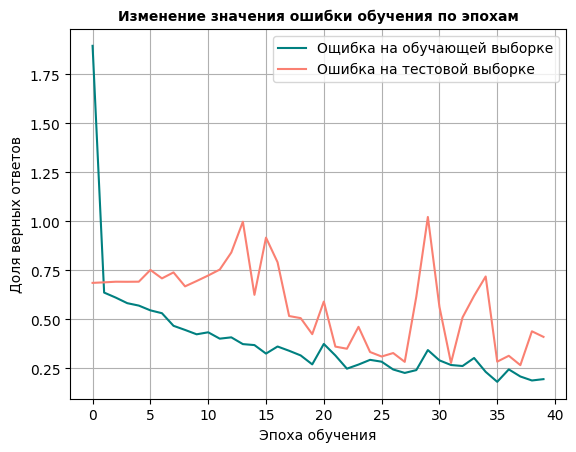

In [ ]:
fig = plt.figure()
plt.plot(history_2.history['loss'], label='Ощибка на обучающей выборке', color='teal')
plt.plot(history_2.history['val_loss'], label='Ошибка на тестовой выборке', color='salmon')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения ошибки обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

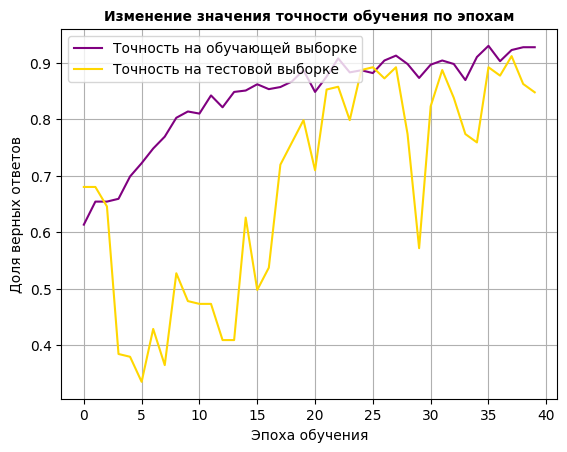

In [ ]:
fig = plt.figure()
plt.plot(history_2.history['accuracy'], label='Точность на обучающей выборке', color='purple')
plt.plot(history_2.history['val_accuracy'], label='Точность на тестовой выборке', color='gold')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения точности обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
predicted_probabilities = model_2.predict(test_images)

16/16 [==============================] - 0s 29ms/step


In [ ]:
filtered_test_df['target'] = predicted_probabilities

In [ ]:
filtered_test_df

id        target
333  11kFDwoijA.jpeg  9.219513e-03
458  0R1JRbHS33.jpeg  3.462686e-03
416   0HBgVT0VvK.png  8.748183e-01
429   10Slzb9e4j.png  2.936000e-01
287  11ynarQSJR.jpeg  1.370742e-01
..               ...           ...
220  zYKWQZdgyq.jpeg  2.058583e-05
335   zywTjOni8G.png  6.723265e-01
365  zYGRpPCsTX.jpeg  1.743454e-02
505  Zx8GAhtKvo.jpeg  2.300565e-01
178  ZXNUZqQabf.jpeg  8.579806e-09

[506 rows x 2 columns]

In [ ]:
filtered_test_df['target'] = filtered_test_df['target'].round(5)

In [ ]:
filtered_test_df

id  target
333  11kFDwoijA.jpeg     0.0
458  0R1JRbHS33.jpeg     0.2
416       0HBgVT0VvK     0.8
429       10Slzb9e4j     1.0
287  11ynarQSJR.jpeg     0.1
..               ...     ...
220  zYKWQZdgyq.jpeg     0.0
335       zywTjOni8G     0.6
365  zYGRpPCsTX.jpeg     0.0
505  Zx8GAhtKvo.jpeg     0.3
178  ZXNUZqQabf.jpeg     0.0

[506 rows x 2 columns]

In [ ]:
# Удаление строки '.png' из столбца id, кроме файла '66ZTFIsZeg.png'
filtered_test_df['id'] = filtered_test_df.apply(lambda row: row['id'].replace('.png', '') if row['id'] != '66ZTFIsZeg.png' else row['id'], axis=1)

In [ ]:
filtered_test_df

id  target
333  11kFDwoijA.jpeg   0.009
458  0R1JRbHS33.jpeg   0.003
416       0HBgVT0VvK   0.875
429       10Slzb9e4j   0.294
287  11ynarQSJR.jpeg   0.137
..               ...     ...
220  zYKWQZdgyq.jpeg   0.000
335       zywTjOni8G   0.672
365  zYGRpPCsTX.jpeg   0.017
505  Zx8GAhtKvo.jpeg   0.230
178  ZXNUZqQabf.jpeg   0.000

[506 rows x 2 columns]

In [ ]:
filtered_test_df.to_csv('submission_9.csv', header=True, index=False)

### **Спецификация №3**

Используем предобученную модель MobileNetV2 без верхних слоев для извлечения признаков из изображений. После базовой модели добавляется слой GlobalAveragePooling2D для усреднения признаков и полносвязный слой с сигмоидной активацией для предсказания вероятности. Модель компилируется с оптимизатором Adam и функцией потерь binary_crossentropy.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [ ]:
# Загружаем предобученную модель MobileNetV2 без верхних слоев и указываем размер входных изображений
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

# Замораживаем веса базовой модели
base_model.trainable = False

# Создаем модель для обучения
model_3 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
# Компилируем модель
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучаем модель на тренировочных данных
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35)

Epoch 1/35
26/26 [==============================] - 10s 182ms/step - loss: 0.6243 - accuracy: 0.6489 - val_loss: 0.4984 - val_accuracy: 0.7685
Epoch 2/35
26/26 [==============================] - 2s 70ms/step - loss: 0.4735 - accuracy: 0.7750 - val_loss: 0.4151 - val_accuracy: 0.7980
Epoch 3/35
26/26 [==============================] - 2s 70ms/step - loss: 0.3906 - accuracy: 0.8541 - val_loss: 0.3681 - val_accuracy: 0.8374
Epoch 4/35
26/26 [==============================] - 2s 89ms/step - loss: 0.3357 - accuracy: 0.8789 - val_loss: 0.3366 - val_accuracy: 0.8473
Epoch 5/35
26/26 [==============================] - 2s 86ms/step - loss: 0.3000 - accuracy: 0.8925 - val_loss: 0.3163 - val_accuracy: 0.8571
Epoch 6/35
26/26 [==============================] - 2s 70ms/step - loss: 0.2714 - accuracy: 0.9135 - val_loss: 0.3033 - val_accuracy: 0.8621
Epoch 7/35
26/26 [==============================] - 2s 71ms/step - loss: 0.2508 - accuracy: 0.9258 - val_loss: 0.2949 - val_accuracy: 0.8719
Epoch 8/35


In [ ]:
filtered_test_df['target'] = ""

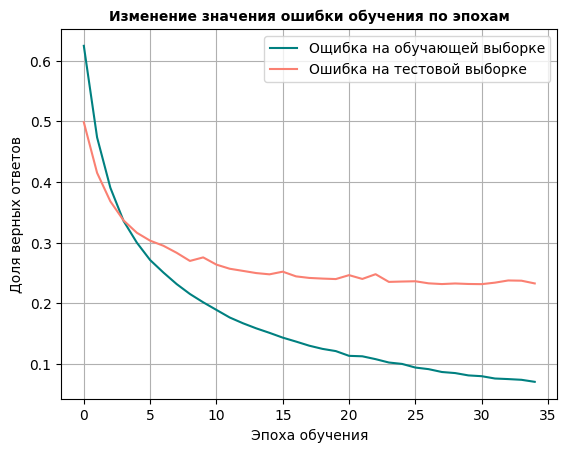

In [ ]:
fig = plt.figure()
plt.plot(history_3.history['loss'], label='Ощибка на обучающей выборке', color='teal')
plt.plot(history_3.history['val_loss'], label='Ошибка на тестовой выборке', color='salmon')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения ошибки обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

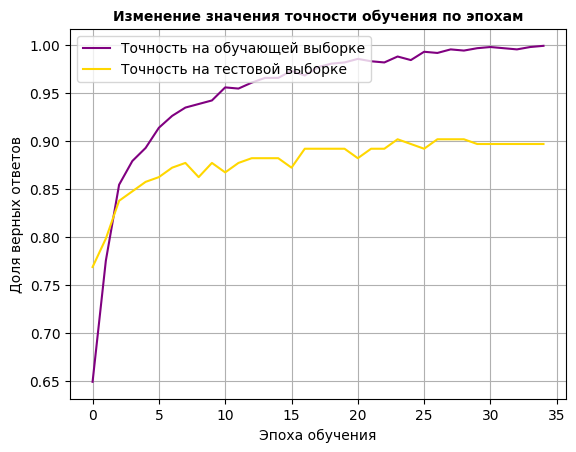

In [ ]:
fig = plt.figure()
plt.plot(history_3.history['accuracy'], label='Точность на обучающей выборке', color='purple')
plt.plot(history_3.history['val_accuracy'], label='Точность на тестовой выборке', color='gold')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения точности обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
predicted_probabilities = model_3.predict(test_images)

16/16 [==============================] - 3s 119ms/step


In [ ]:
filtered_test_df['target'] = predicted_probabilities

In [ ]:
filtered_test_df['target'] = filtered_test_df['target'].round(4)

In [ ]:
# Удаление строки '.png' из столбца id, кроме файла '66ZTFIsZeg.png'
filtered_test_df['id'] = filtered_test_df.apply(lambda row: row['id'].replace('.png', '') if row['id'] != '66ZTFIsZeg.png' else row['id'], axis=1)

In [ ]:
filtered_test_df

id  target
333  11kFDwoijA.jpeg  0.0045
458  0R1JRbHS33.jpeg  0.9637
416       0HBgVT0VvK  0.9667
429       10Slzb9e4j  0.9991
287  11ynarQSJR.jpeg  0.0003
..               ...     ...
220  zYKWQZdgyq.jpeg  0.0064
335       zywTjOni8G  0.9749
365  zYGRpPCsTX.jpeg  0.1558
505  Zx8GAhtKvo.jpeg  0.9898
178  ZXNUZqQabf.jpeg  0.0003

[506 rows x 2 columns]

In [ ]:
filtered_test_df.to_csv('submission_10.csv', header=True, index=False)

**Усовершенствуем модель:

In [ ]:
# Размораживаем несколько верхних слоев базовой модели
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Добавляем Dropout
model_3_1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Компилируем модель
model_3_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучаем модель на тренировочных данных
history_3_1 = model_3_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40)

Epoch 1/40
26/26 [==============================] - 16s 145ms/step - loss: 0.6185 - accuracy: 0.6613 - val_loss: 0.6957 - val_accuracy: 0.5813
Epoch 2/40
26/26 [==============================] - 2s 72ms/step - loss: 0.2159 - accuracy: 0.9271 - val_loss: 0.4034 - val_accuracy: 0.8325
Epoch 3/40
26/26 [==============================] - 2s 72ms/step - loss: 0.1154 - accuracy: 0.9765 - val_loss: 0.4450 - val_accuracy: 0.8325
Epoch 4/40
26/26 [==============================] - 2s 70ms/step - loss: 0.0578 - accuracy: 0.9926 - val_loss: 0.4101 - val_accuracy: 0.8522
Epoch 5/40
26/26 [==============================] - 2s 72ms/step - loss: 0.0305 - accuracy: 0.9988 - val_loss: 0.5823 - val_accuracy: 0.7882
Epoch 6/40
26/26 [==============================] - 2s 72ms/step - loss: 0.0281 - accuracy: 0.9975 - val_loss: 0.6553 - val_accuracy: 0.7833
Epoch 7/40
26/26 [==============================] - 2s 79ms/step - loss: 0.0191 - accuracy: 0.9963 - val_loss: 0.5601 - val_accuracy: 0.8177
Epoch 8/40


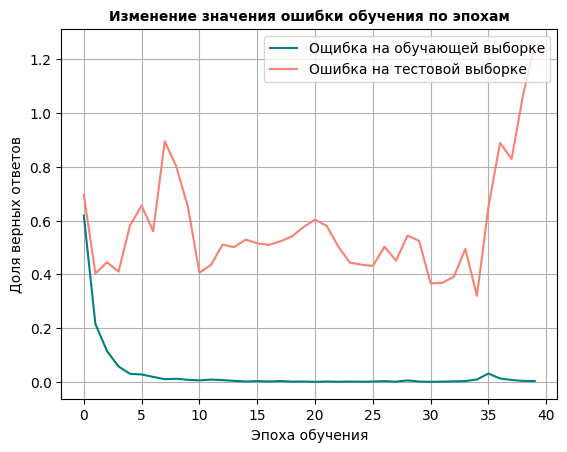

In [ ]:
fig = plt.figure()
plt.plot(history_3_1.history['loss'], label='Ощибка на обучающей выборке', color='teal')
plt.plot(history_3_1.history['val_loss'], label='Ошибка на тестовой выборке', color='salmon')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения ошибки обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

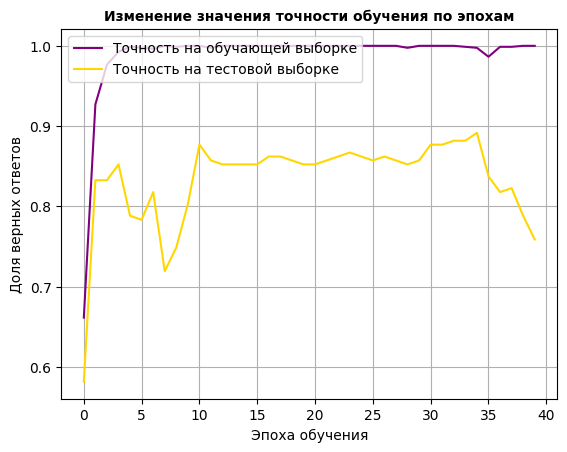

In [ ]:
fig = plt.figure()
plt.plot(history_3_1.history['accuracy'], label='Точность на обучающей выборке', color='purple')
plt.plot(history_3_1.history['val_accuracy'], label='Точность на тестовой выборке', color='gold')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения точности обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
predicted_probabilities = model_3.predict(test_images)

16/16 [==============================] - 1s 35ms/step


In [ ]:
filtered_test_df['target'] = predicted_probabilities

In [ ]:
filtered_test_df['target'] = filtered_test_df['target'].round(3)

In [ ]:
# Удаление строки '.png' из столбца id, кроме файла '66ZTFIsZeg.png'
filtered_test_df['id'] = filtered_test_df.apply(lambda row: row['id'].replace('.png', '') if row['id'] != '66ZTFIsZeg.png' else row['id'], axis=1)

In [ ]:
filtered_test_df

id  target
333  11kFDwoijA.jpeg   0.287
458  0R1JRbHS33.jpeg   0.498
416       0HBgVT0VvK   0.239
429       10Slzb9e4j   0.297
287  11ynarQSJR.jpeg   0.473
..               ...     ...
220  zYKWQZdgyq.jpeg   0.523
335       zywTjOni8G   0.165
365  zYGRpPCsTX.jpeg   0.542
505  Zx8GAhtKvo.jpeg   0.417
178  ZXNUZqQabf.jpeg   0.519

[506 rows x 2 columns]

In [ ]:
filtered_test_df.to_csv('submission_3-3.csv', header=True, index=False)

## **Спецификация 4**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

In [ ]:
def build_model(input_shape):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the convolutional base

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Add dropout to prevent overfitting
        layers.Dense(1, activation='sigmoid')  # Sigmoid function for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = X_train.shape[1:]  # Get the input shape from your training data

In [ ]:
input_shape

(224, 224, 3)

In [ ]:
model_4 = build_model(input_shape)

TypeError: object of type 'int' has no len()

In [ ]:
# Data Augmentation to create more diverse training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that validation data shouldn't be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Preprocess and augment training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=20)
val_generator = val_datagen.flow(X_val, y_val, batch_size=20)

In [ ]:
# Train the model
history_4 = model_4.fit(
    train_generator,
    steps_per_epoch=100,  # Number of steps per epoch. Adjust based on your dataset.
    epochs=30,  # Starting with 30. Adjust based on your training curve.
    validation_data=val_generator,
    validation_steps=50)  # Adjust based on your validation data

# Model Evaluation
loss, accuracy = model_4.evaluate(X_val, y_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/30
 41/100 [===========>..................] - ETA: 14s - loss: 1.0942 - accuracy: 0.5204

7/7 [==============================] - 2s 131ms/step - loss: 0.6828 - accuracy: 0.6108
Loss: 0.6827982664108276, Accuracy: 0.610837459564209


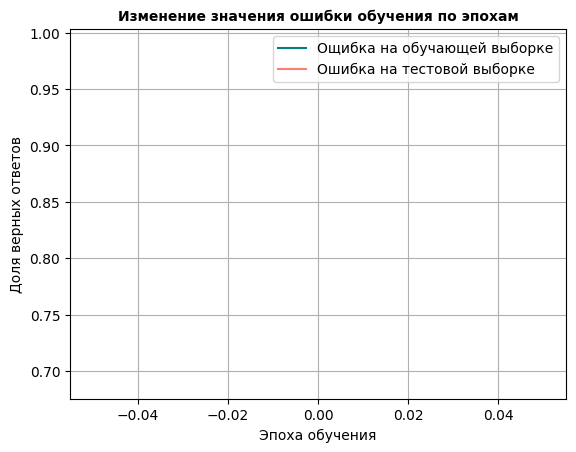

In [ ]:
fig = plt.figure()
plt.plot(history_4.history['loss'], label='Ощибка на обучающей выборке', color='teal')
plt.plot(history_4.history['val_loss'], label='Ошибка на тестовой выборке', color='salmon')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения ошибки обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

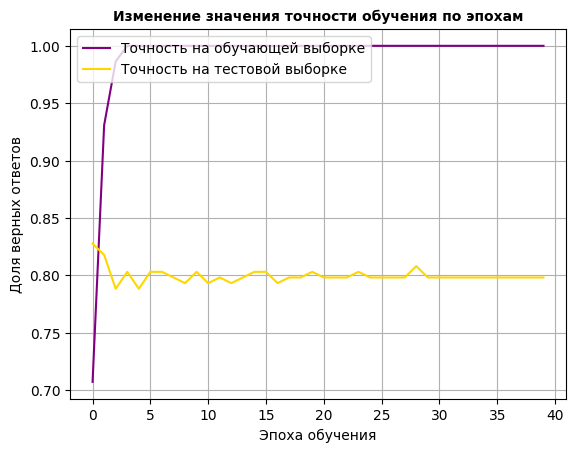

In [ ]:
fig = plt.figure()
plt.plot(history_4.history['accuracy'], label='Точность на обучающей выборке', color='purple')
plt.plot(history_4.history['val_accuracy'], label='Точность на тестовой выборке', color='gold')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.title('Изменение значения точности обучения по эпохам', fontsize=10, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# новая попытка

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
train_path = '/content/drive/My Drive/тестовое/train/'
test_path = '/content/drive/My Drive/тестовое/test/'

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize images to 64x64
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color scheme from BGR to RGB
            images.append(img)
    return np.array(images)

In [ ]:
def load_labels(folder):
    # You should implement how to load your labels here. For now, we'll just create an array of zeros.
    labels = np.zeros((len(os.listdir(folder)),), dtype=int)
    return labels

In [ ]:
train_images = load_images_from_folder(train_path)
test_images = load_images_from_folder(test_path)

In [ ]:
# Hypothetic function to load labels
train_labels = load_labels(train_path) # You should implement actual label loading logic
test_labels = load_labels(test_path) # Dummy, same as above

# Splitting train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32)

Epoch 1/40
26/26 [==============================] - 9s 309ms/step - loss: 0.2941 - accuracy: 0.9889 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/40
26/26 [==============================] - 5s 206ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/40
26/26 [==============================] - 6s 241ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/40
26/26 [==============================] - 5s 174ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/40
26/26 [==============================] - 5s 178ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/40
26/26 [==============================] - 6s 241ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/40
26/26 [==============================] - 5s 175ms/step - loss: 0.0000e+00 - accuracy: 1.0000 

In [ ]:
predicted_probabilities = model.predict(test_images)

16/16 [==============================] - 1s 42ms/step


In [ ]:
filtered_test_df['target'] = predicted_probabilities

In [ ]:
filtered_test_df['target'] = filtered_test_df['target'].round(4)

In [ ]:
# Удаление строки '.png' из столбца id, кроме файла '66ZTFIsZeg.png'
filtered_test_df['id'] = filtered_test_df.apply(lambda row: row['id'].replace('.png', '') if row['id'] != '66ZTFIsZeg.png' else row['id'], axis=1)

In [ ]:
filtered_test_df

id  target
333  11kFDwoijA.jpeg     0.0
458  0R1JRbHS33.jpeg     0.0
416       0HBgVT0VvK     0.0
429       10Slzb9e4j     0.0
287  11ynarQSJR.jpeg     0.0
..               ...     ...
220  zYKWQZdgyq.jpeg     0.0
335       zywTjOni8G     0.0
365  zYGRpPCsTX.jpeg     0.0
505  Zx8GAhtKvo.jpeg     0.0
178  ZXNUZqQabf.jpeg     0.0

[506 rows x 2 columns]

In [ ]:
filtered_test_df.to_csv('submission_5.csv', header=True, index=False)